In [4677]:
from sympy import init_session
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.integrate as it
from scipy.signal import savgol_filter


init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [4678]:
# Size
a = 1.97 * 0.0254 #m R2
b = 12.4 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [4679]:
m = 3.8 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/12 * m * l**2 + m * (l/2 * sqrt(2))**2 + 1/3 * m * l**2#moment of inertia about com kgm^2
mu_k = 0.3  # coefficient of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 25 #degs
n = 3 # order of polynomial filtering 
b = 61 # window size for filter need to be odd number
I

In [4680]:
#Parameters
motor_torque = 35 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_43 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])
#df.head(20)
#print(df.shape[0])
results = motor_torque * ((c * np.sin(np.deg2rad(156.133)))/ (a * np.sin(np.deg2rad(0.33))))
results2 = motor_torque * ((c * np.sin(np.deg2rad(156.133)))/ (a))
print(results2)

22.787831667256235


In [4681]:
#Torque Calculations

tau_out = []
err = 15 # to eliminate spikes and use small angle approximation
for i in range(df.shape[0]):
    theta_a = 180.0 - df["theta_2 [°]"][i] + df["theta_3 [°]"][i] # inner angle between link a and b
    theta_b = df["theta_4 [°]"][i]- df["theta_3 [°]"][i] # inner angle between link b and c
    if abs(theta_a) > err and abs(theta_a) < (180-err):
        temp1 = motor_torque * ((c * np.sin(np.deg2rad(theta_b)))/ (a * np.sin(np.deg2rad(theta_a))))
        tau_out.append(temp1)
    elif abs(theta_b) < err and abs(theta_a) > (180-err):
        temp2 = motor_torque * (c)/ (a)
        tau_out.append(temp2)
    else: 
        temp3 = motor_torque * (c)/ (a)
        tau_out.append(temp3)

filter_tau_out = savgol_filter(tau_out, b, n)
df["Input_Torque [nm]"] = filter_tau_out
print(df["Input_Torque [nm]"].to_string())

0     -54.994244
1     -59.536047
2     -63.253788
3     -66.180387
4     -68.348760
5     -69.791825
6     -70.542498
7     -70.633697
8     -70.098341
9     -68.969345
10    -67.279627
11    -65.062105
12    -62.349695
13    -59.175316
14    -55.571885
15    -51.572318
16    -47.209533
17    -42.516448
18    -37.525980
19    -32.271046
20    -26.784563
21    -21.099450
22    -15.248622
23     -9.264998
24     -3.181495
25      2.968970
26      9.153479
27     15.339116
28     21.492962
29     27.582101
30     33.573615
31     37.905114
32     42.057536
33     46.024446
34     49.777102
35     53.277551
36     56.471057
37     59.269762
38     62.670063
39     65.830638
40     68.730996
41     71.348979
42     73.660387
43     75.638500
44     77.253458
45     78.471431
46     79.253494
47     83.133780
48     85.649926
49     86.854420
50     86.746705
51     85.279382
52     82.351287
53     77.784250
54     71.267729
55     69.030240
56     66.349797
57     63.252971
58     59.7647

In [4682]:
# Equations of Motion
acceleration_t = []
force_spring = []
alpha_w = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = (df["Input_Torque [nm]"][i] - m * g * np.cos(np.radians(theta)))/ I  #alpha
    alpha_w.append(temp7)
    
    temp8 = l * alpha_w[i] #use a = r*alpha to find tangential acceleration
    acceleration_t.append(temp8)
    
    temp9 = l * (df["Input_Torque [nm]"][i]) + m * acceleration_t[i] #friction
    F_friction.append(temp8)

    temp10 = F_friction[i] / mu_k #Normal force
    F_n.append(temp10)
    
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) #Spring Force
    force_spring.append(temp11)
    
df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_t
df["alpha_w [rad/s^2]"] = alpha_w
df["F_spring [N]"]= force_spring
df.head()

,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,-54.994244,-136.520234018300,-40.9560702054901,-40.9560702054901,-65.8140289337780,-170.305575703452
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,-59.536047,-143.504361046277,-43.0513083138832,-43.0513083138832,-69.1809550279338,-177.289702731430
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,0.0,-11.020230,-4.328158,-63.253788,-149.221294468791,-44.7663883406372,-44.7663883406372,-71.9369891380962,-183.006636153943
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,0.0,-11.345834,-3.681429,-66.180387,-153.721652698377,-46.1164958095130,-46.1164958095130,-74.1065335200274,-187.506994383529
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,0.0,-11.609664,-2.929573,-68.348760,-157.056054147572,-47.1168162442715,-47.1168162442715,-75.7139904294898,-190.841395832724


In [4683]:
#Use trapezoidal rule to find v by integration
dt = 0.0001
v_tan = it.cumulative_trapezoid(y = df["acc_tan [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
#v_nor = it.cumulative_trapezoid(y = df["acc_nor [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
df["vel_tan [m/s]"] = v_tan
#df["vel_nor [m/s]"] = v_nor


In [4684]:
#Use trapezoidal rule to find position by integration
dt = 0.0001
tan = it.cumulative_trapezoid(y = df["vel_tan [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
#nor = it.cumulative_trapezoid(y = df["vel_nor [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
df["pos_tan [m]"] = tan
#df["pos_nor [m]"] = nor

In [4685]:
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],...,alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N],vel_tan [m/s],pos_tan [m]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,...,-10.640384,-4.887655,-54.994244,-136.520234018300,-40.9560702054901,-40.9560702054901,-65.8140289337780,-170.305575703452,0,0
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,...,-10.640384,-4.887655,-59.536047,-143.504361046277,-43.0513083138832,-43.0513083138832,-69.1809550279338,-177.289702731430,-0.420036892596866,-0.00210018446298433
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,...,-11.020230,-4.328158,-63.253788,-149.221294468791,-44.7663883406372,-44.7663883406372,-71.9369891380962,-183.006636153943,-0.859125375869469,-0.00849599580531601
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,...,-11.345834,-3.681429,-66.180387,-153.721652698377,-46.1164958095130,-46.1164958095130,-74.1065335200274,-187.506994383529,-1.31353979662022,-0.0193593216677644
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,...,-11.609664,-2.929573,-68.348760,-157.056054147572,-47.1168162442715,-47.1168162442715,-75.7139904294898,-190.841395832724,-1.77970635688914,-0.0348255524353113


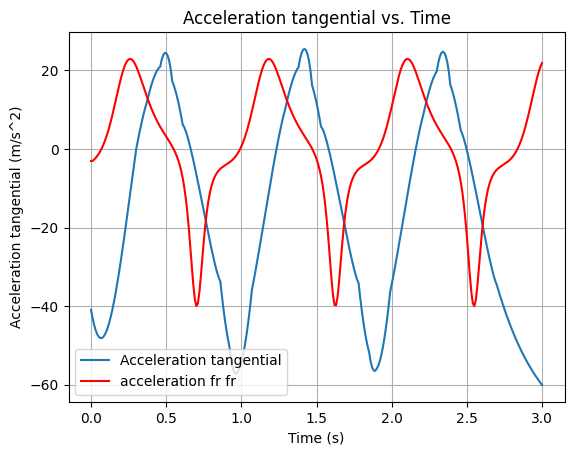

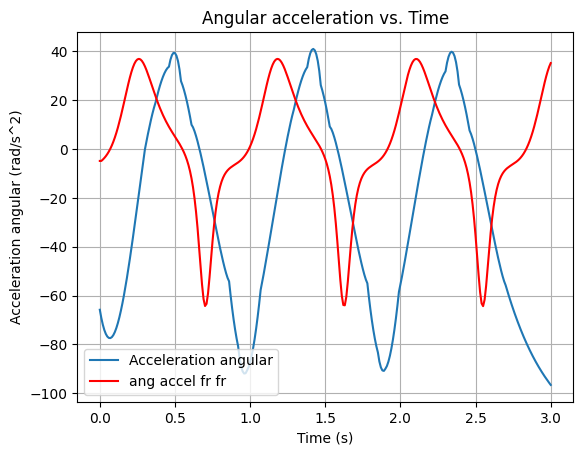

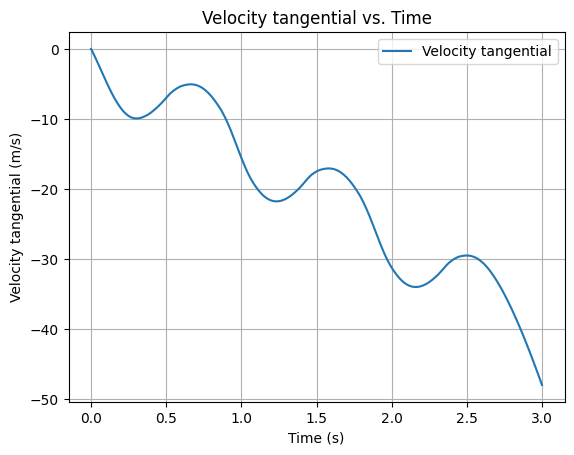

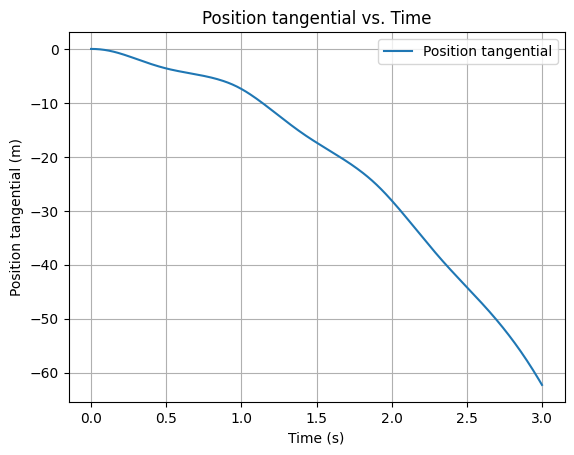

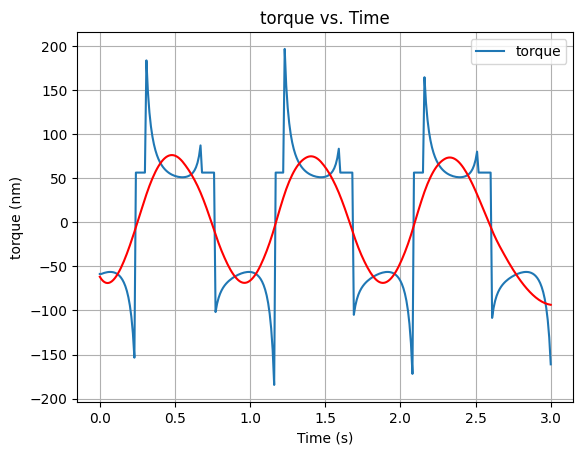

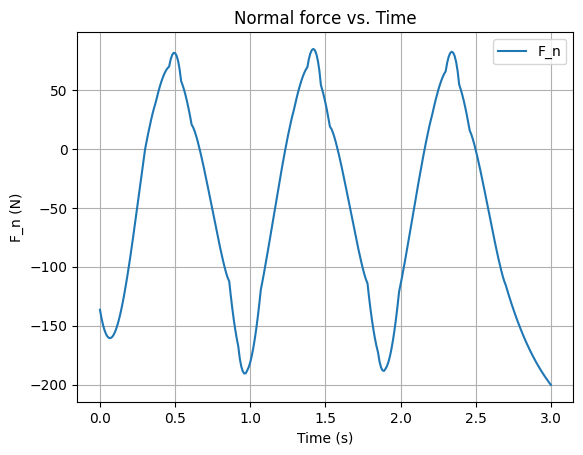

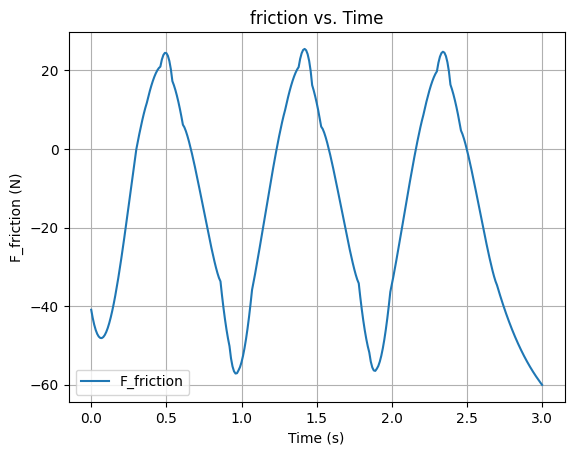

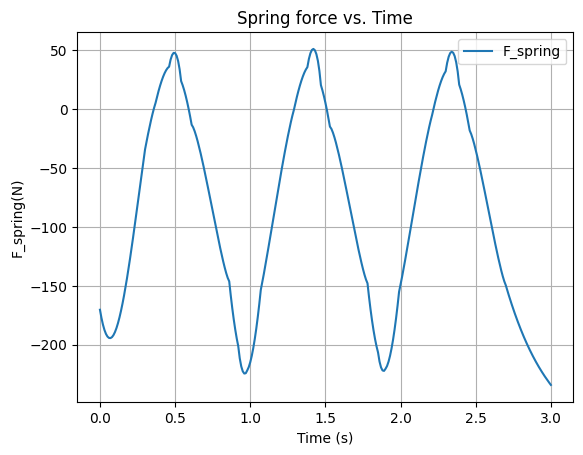

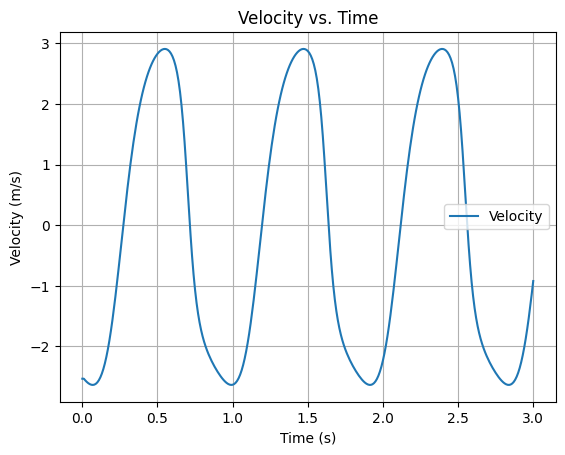

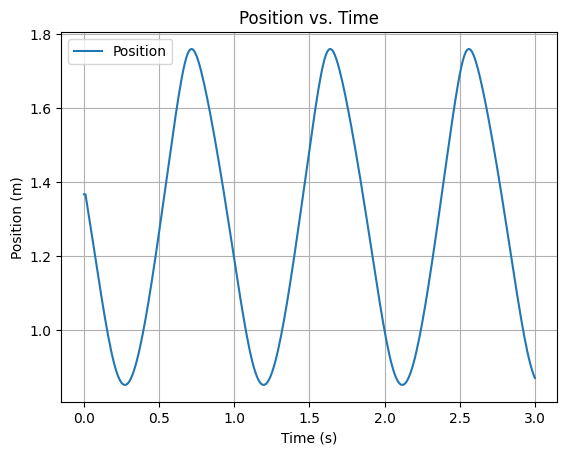

In [4686]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='acceleration fr fr', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["alpha_w [rad/s^2]"], label='Acceleration angular')
plt.plot(df["time [s]"], df["alpha_4 [rad/s^2]"], label='ang accel fr fr ', color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration angular (rad/s^2)')
plt.title('Angular acceleration vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')
plt.legend()
plt.grid()
yhat = savgol_filter(df["Input_Torque [nm]"], b, n) # window size b, polynomial order n
plt.plot(df["time [s]"],yhat, color = 'red')
plt.show()


plt.plot(df["time [s]"], df["F_normal [N]"], label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Friction [N]"], label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_spring [N]"], label='F_spring')
plt.xlabel('Time (s)')
plt.ylabel('F_spring(N)')
plt.title('Spring force vs. Time')
plt.legend()
plt.grid()
plt.show()



plt.plot(df["time [s]"], l * df["omega_4 [rad/s]"], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["theta_4 [rad]"], label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs. Time')
plt.legend()
plt.grid()
plt.show()